<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/Meta-analise/Meta_analysis_using_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta-analysis using Python: a hands-on tutorial

> doi: https://doi.org/10.1186/s12874-022-01673-y


Este notebook contém os códigos do material suplementar do artigo em questão, organizados em células separadas:

1. Tabela 1 – Teste de Egger  
2. Figura 1 – Resultados de modelo fixo e randômico  
3. Criação dos datasets com e sem missing  
4. Figura 2 – Forest plot combinando modelos e intervalo de predição  
5. Figura 3 – Forest plot com subgrupos (com/sem missing)  
6. Criação dos datasets de imputação (ICA-0, ICA-1, ICA-WORST, ICA-BEST)  
7. Figura 4 – Comparação de métodos de imputação (zEpid)  
8. Figura 5 – Funnel plot  
9. Contour-enhanced funnel plot

> Para rodar: execute as células de cima para baixo. Certifique-se de que os arquivos de dados (`Haloperidol.txt`, `Cochrane.csv`, etc.) estão na mesma pasta do notebook.


In [11]:
# Instalação dos pacotes necessários.
# Aqui deixo em forma de comando para notebooks como Colab.

!pip install PythonMeta

## Tabela 1 – Teste de Egger

In [2]:
import PythonMeta as PMA
import math
import numpy as np
import statsmodels.api as sm

# Table 1: Egger`s test result for assessing funnel plot symmetry and small study effect
# Eggers`s test: is obtained by regressing the standardized effect size on the inverse of the standard error (the precision)
# We use this test to assess the funnel plot asymmetry

def SEeff(results):   #effect size
    SND=[]
    for i in range(1, len(results)):
        SEF = math.log(results[i][1]) / results[i][6]
        SND.append(SEF)
    return(SND)

def RevSE(results):    #precision
    Se=[]
    for i in range(1, len(results)):
        rese = 1 / results[i][6]
        Se.append(rese)
    return(Se)

def main(setting):
    d = PMA.Data()  # Load Data class
    m = PMA.Meta()  # Load Meta class

    d.datatype = setting["datatype"]
    studies = d.getdata(d.readfile("/content/ Haloperidol.txt"))
    m.datatype = d.datatype
    m.models = setting["models"]
    m.algorithm = setting["algorithm"]
    m.effect = setting["effect"]
    results = m.meta(studies)

    x = np.array(RevSE(results))
    y = np.array(SEeff(results))
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    print(est.summary())

if __name__ == '__main__':
    settings = {"datatype": "CATE",
                "models": "random",
                "algorithm": "iv",
                "effect": "RR"}
    main(settings)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.801
Date:                Mon, 24 Nov 2025   Prob (F-statistic):              0.200
Time:                        00:34:51   Log-Likelihood:                -15.906
No. Observations:                  17   AIC:                             35.81
Df Residuals:                      15   BIC:                             37.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7894      0.257      6.950      0.0

## Figura 1 – Resultados dos modelos fixo e randômico

In [3]:
# Figure 1:  The results of the Fixed and random effect Meta-analysis
# We modified the package code to obtain more inclusive figure.
# We combine fixed effect and random effect in one figure and add details on the bottom of the figure

import PythonMeta as PMA
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D

def showresults(fixed_results, random_results):
    text = "{0:<20} {1:<8} {2:18} {3:10} {4}"\
           .format("Study ID", "n", "ES[95% CI]","Fixed Wt(%)", "Random Wt(%)\n\n")
    for i in range(1, len(fixed_results)):
        NewId=(fixed_results[i][0]).replace("<sub>","")
        if (fixed_results[i][0]).startswith("<sub>"):
            Id= NewId
        else:
            Id=fixed_results[i][0]
        text += "{0:<20} {1:<6} {2:5.2f}[{3:<6.2f}{4:<6.2f}]   "      "{5:<11.2f} {6:<15.2f} \n".format(  # for each study
                                Id,   # study ID
                                fixed_results[i][5],   # total num
                                fixed_results[i][1],   # effect size
                                fixed_results[i][3],   # lower of CI
                                fixed_results[i][4],   # higher of CI
                                100*(fixed_results[i][2]/fixed_results[0][2]),   # Fixed weight
                                100*(random_results[i][2]/random_results[0][2]))# Random weight

    text += "\n{0:<20} {1:<7} {2:5.2f}[{3:<6.2f}  {4:<6.2f}] Z={5:<.3} P-value={6:<.20}  \n".format(  # for total effect
        "Fixed Effect Model",  # total effect size model  name
        fixed_results[0][5],  # total N (all studies)
        fixed_results[0][1],  # total effect size
        fixed_results[0][3],  # total lower CI
        fixed_results[0][4],  # total higher CI
        fixed_results[0][10],
        fixed_results[0][11]
        )

    text += "{0:<20} {1:<7} {2:5.2f}[{3:<6.2f}  {4:<6.2f}] Z={5:<.3} P-value={6:<.20} \n".format(  # for total effect
        "Random Effect Model",  # total effect size model name
        random_results[0][5],  # total N (all studies)
        random_results[0][1],  # total effect size
        random_results[0][3],  # total lower CI
        random_results[0][4],  # total higher CI
        random_results[0][10],
        random_results[0][11],
        )
    text += "\n{0:<d}studies included (N={1:<d})\n".format( len(fixed_results) - 1, fixed_results[0][5])
    text += "\nQuantifying Heterogeneity: \n" "Tau²={0:.3f} I²={1:s}\n".format(
        random_results[0][12],
        str(round(random_results[0][9], 2)) + "%")

    text += "\nTest of heterogeneity:\n" "Q={0:.2f} p-value={1:s} \n".format(
        fixed_results[0][7],  # Q test value
        fixed_results[0][8],  # p value for Q test
       )
    text+= "\n{0:s}\n {1:s}\n {2:s}\n {3:s}".format("Details on meta-analysis method:",
                                                    "-Mantel-Haenszel method",
                                                    "-DerSimonian and Laird for Tau²",
                                                    "-Continuity correction of 0.5 in studies with zero cell")
    return text

def main(setting):
    d = PMA.Data()  # Load Data class
    m = PMA.Meta()  # Load Meta class
    d.datatype = setting["datatype"]  # set data type, 'CATE' for binary data or 'CONT' for continuous data
    studies = d.getdata(d.readfile("/content/ Haloperidol.txt"))  # get data from a data file
    m.subgroup = d.subgroup
    m.datatype = d.datatype  # set data type for meta-analysis calculating
    m.models = setting["models"][0]  # set effect models: 'Fixed'
    m.algorithm = setting["algorithm"]  # set algorithm, based on datatype and effect size
    m.effect = setting["effect"]  # set effect size:RR/OR/RD for binary data; SMD/MD for continuous data
    results = m.meta(studies)  # performing the analysis
    m.models = setting["models"][1]  #set effect models: Random"
    res_random = m.meta(studies)
    print(showresults(results, res_random))
    # Para salvar como figura de texto, descomente abaixo:
    # plt.rc('figure', figsize=(8, 8))
    # plt.text(0.01, 0.02, str((showresults(results, res_random))), {'fontsize':14},family="open-Sans", fontproperties = 'monospace')
    # plt.axis('off')
    # plt.savefig('Figure1.png',dpi=400,bbox_inches="tight",orientation="landscape")

if __name__ == '__main__':
    settings = {"datatype": "CATE",  # for CATEgorical/count/binary/dichotomous data
                "models": ["Fixed", "Random"],  # models: Fixed or Random
                "algorithm": "MH",  # algorithm: MH, Peto or IV
                "effect": "RR"}  # effect size: RR, OR, RD
    main(settings)

Study ID             n        ES[95% CI]         Fixed Wt(%) Random Wt(%)

Arvanitis1997        101     1.42[0.89  2.25  ]   21.10       13.00           
Beasley1996          81      1.05[0.73  1.50  ]   27.48       14.02           
Bechelli1983         59      6.21[1.52  25.35 ]   2.33        5.19            
Borison1992          24      7.00[0.40  122.45]   0.59        1.66            
Chouinard1993        43      3.49[1.11  10.95 ]   3.47        6.73            
Durost1964           34      8.68[1.26  59.95 ]   1.32        3.25            
Garry1962            50      1.75[0.58  5.24  ]   4.74        7.06            
Howard1974           30      2.04[0.67  6.21  ]   4.03        6.94            
Marder1994           128     1.36[0.75  2.47  ]   16.58       11.60           
Nishikawa1982        20      3.00[0.14  65.91 ]   0.59        1.45            
Nishikawa1984        47      9.20[0.58  145.77]   0.85        1.77            
Reschke1974          40      3.79[1.06  13.60 ]   3.43  

## Criação dos datasets com e sem missing (Cochrane.csv → withMiss.csv / Withoutmiss.csv)

In [4]:
# Create datasets for missing and without missing studies
import numpy as np
import pandas as pd

df = pd.read_csv("/content/Cochrane.csv")
withmiss = df.loc[(df["drop.h"] != 0) | (df["drop.p"] != 0)]
withmiss.to_csv("withMiss.csv", index=False)

Withoutmiss = df.loc[(df["drop.h"] == 0) & (df["drop.p"] == 0)]
Withoutmiss.to_csv("Withoutmiss.csv", index=False)

print("Arquivos 'withMiss.csv' e 'Withoutmiss.csv' criados.")

Arquivos 'withMiss.csv' e 'Withoutmiss.csv' criados.


## Figura 2 – Forest plot combinando fixed/random + intervalo de predição

/usr/local/lib/python3.12/dist-packages/PythonMeta/core.py:3546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(_x_tran1(x),2) for x in ax.get_xticks()])


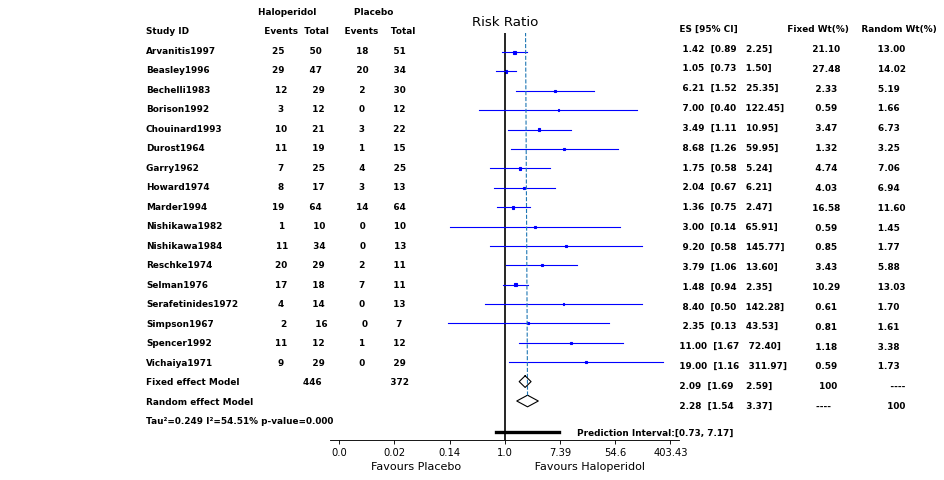

In [5]:
# Figure 2. Forest plot showing the results of fixed effect and random effects meta-analysis (ES: effect size)
# We modify the package source code. We included the prediction interval and combined random and fixed effect results.

import PythonMeta as PMA
import matplotlib.pyplot as plt
import scipy.stats
import math
from pylab import gca
from matplotlib.lines import Line2D

def showstudy(studies):
    text = "{0:22}{1:20}\n".format( "Haloperidol ", " Placebo")
    text += "{0:80}{1:10}{2:10}{3:10}{4:10}\n".format("   ","  Events","Total","Events","Total")
    for i in range(len(studies)):
        text += "{0:10}{1:13}{2:10}{3:10}\n".format(
        str(studies[i][0]),   #event num of group1
        str(studies[i][1]),   #total num of group1
        str(studies[i][2]),   #event num of group2
        str(studies[i][3]),)   #total num of group2
    text += "{0:25}{1:10}".format("446","372")
    return text

def studyID(studies,random_results):
    text="{0:23}\n".format( "Study ID")
    for i in range(len(studies)):
        text += "{0:10}\n".format(studies[i][4])        #study ID
    text+="Fixed effect Model\n""Random effect Model\n""Tau²={0:.3f} I²={1:s} p-value={2:s}".format(
     random_results[0][12],
     str(round(random_results[0][9], 2)) + "%",
     random_results[0][11]
     )
    return text

# Fixed and random effect weights
def descripweight(fixed_results,random_results):
    text = "{0:<16} {1:<}".format("  Fixed Wt(%)" ,"Random Wt(%)\n")
    for i in range(1, len(fixed_results)):
        text +="{0:15.2f}  {1:15.2f}\n".format(
                                100*(fixed_results[i][2]/fixed_results[0][2]),   # Fixed weight
                                100*(random_results[i][2]/random_results[0][2])) # Random weight
    return text

# Show effect size and 95%confidence interval
def descrip(fixed_results,random_results):
    text = "{}".format("   ES [95% CI]\n")
    for i in range(1, len(fixed_results)):
        text +="{:8.2f}  [{:.2f}   {:.2f}]\n" .format(
                                fixed_results[i][1],   # effect size
                                fixed_results[i][3],   # lower of CI
                                fixed_results[i][4],)   # higher of CI
    text += "  {0:5.2f}  [{1:.2f}  {2:6.2f}]{3:>18} {4:>20}\n  {5:5.2f}  [{6:.2f}  {7:6.2f}]{8:>18} {9:>20}".format(
        fixed_results[0][1],  # total effect size
        fixed_results[0][3],  # total lower CI
        fixed_results[0][4],  # total higher CI
        "100",
        "----",
        random_results[0][1],  # total effect size
        random_results[0][3],  # total lower CI
        random_results[0][4],  # total higher CI
        "----",
        "100",
        )
    return text

# Prediction interval helpers
def tausq(random_results):   #Tau-squared
    tausq=(random_results[0][12])
    return tausq

def totalweight(rults):  #total weight
    TW=rults[0][2]
    return TW

def VM(rults):
    VM=1/rults[0][2]
    return VM

def totalWY(rults): #total weight*log effect size
    totalWY=0
    for i in range(1,len(rults)):
        WY=(rults[i][2])*(math.log(rults[i][1]))
        totalWY+=WY
    return totalWY

def M(rults):  #summary mean (log-scale)
    M=totalWY(rults)/totalweight(rults)
    return M

def PI(rults):
    K=(len(rults)-1)
    df=K-2
    t=scipy.stats.t.ppf(q=1-.05/2,df=df)
    MR=M(rults)
    Tausq=tausq(rults)
    VMR=VM(rults)
    UpperPI=math.exp(MR+t*(math.sqrt(Tausq+VMR)))
    LowerPI=math.exp(MR-t*(math.sqrt(Tausq+VMR)))
    return ("Prediction Interval:"+ str([float("{:.2f}".format(LowerPI)),float("{:.2f}".format(UpperPI))]))

def main(setting):
    d = PMA.Data()  # Load Data class
    m = PMA.Meta()  # Load Meta class
    f = PMA.Fig()  # Load Fig class

    d.datatype = setting["datatype"]
    studies = d.getdata(d.readfile("/content/ Haloperidol.txt"))
    m.subgroup = d.subgroup
    m.datatype = d.datatype
    m.models = setting["models"][0]
    m.algorithm = setting["algorithm"]
    m.effect = setting["effect"]
    results = m.meta(studies)
    m.models = setting["models"][1]
    res_random = m.meta(studies)

    f.forest(res_random)  # base forest plot
    plt.text(6,1.5, descrip(results,res_random),fontsize=8, style='normal', ha="left",
         va='bottom',multialignment="left",linespacing=2.55,weight="bold")
    plt.text(10,2.5,descripweight(results,res_random),fontsize=8, style='normal', ha="left",
         va='bottom',multialignment="left",linespacing=2.55,weight="bold")
    plt.text(8.3,0.1, PI(res_random),fontsize=8, style='normal', ha="right",
         va='bottom', multialignment="left",linespacing=2.5,weight="bold")
    plt.plot((math.log(res_random[0][1]),0),((res_random[0][1]),(len(res_random)+200)),linestyle="--", lw=1)
    plt.yticks([])
    plt.text(-13,0.8,studyID(studies,res_random),multialignment="left",fontsize=8,weight="bold",linespacing=2.5)
    plt.text(-18,2.8,showstudy(studies),multialignment="right",fontsize=8,weight="bold",linespacing=2.5)
    plt.title("Risk Ratio",loc="center")
    plt.xlabel("{:<38}{:<s}".format("  Favours Placebo","Favours Haloperidol"),fontsize=10)

    #draw PI line (log scale)
    K=(len(res_random)-1)
    df=K-2
    t=scipy.stats.t.ppf(q=1-.05/2,df=df)
    UpperPI=(M(res_random)+t*(math.sqrt(tausq(res_random)+VM(res_random))))
    LowerPI=(M(res_random)-t*(math.sqrt(tausq(res_random)+VM(res_random))))
    plt.plot((LowerPI,UpperPI),(0.4,0.4),color="black",lw=3)

    # the total effect size diamond for fixed effect model
    x=[math.log(results[0][1]),
           math.log(results[0][3]),
           math.log(results[0][1]),
           math.log(results[0][4]),
           math.log(results[0][1])]
    y=[3.3,3,2.7,3,3.3]
    if (results[0][9]<50) :
        plt.fill(x,y,color="black", lw=1)  #filled: I2<50
    else :
        plt.plot(x,y, 'black', lw=1)       #empty: I2>50
    ax=plt.gca()
    ax.spines['top'].set_visible(False)

    plt.savefig("Forest_plot_figure2.jpg", dpi=500,bbox_inches="tight",orientation="landscape")
    plt.show()

if __name__ == '__main__':
    settings = {"datatype": "CATE",
                "models": ["Fixed", "Random"],
                "algorithm": "MH",
                "effect": "RR"}
    main(settings)

## Figura 3 – Forest plot com subgrupos (com e sem missing)

/tmp/ipython-input-3742681839.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(_x_tran1(x),2) for x in ax.get_xticks()])


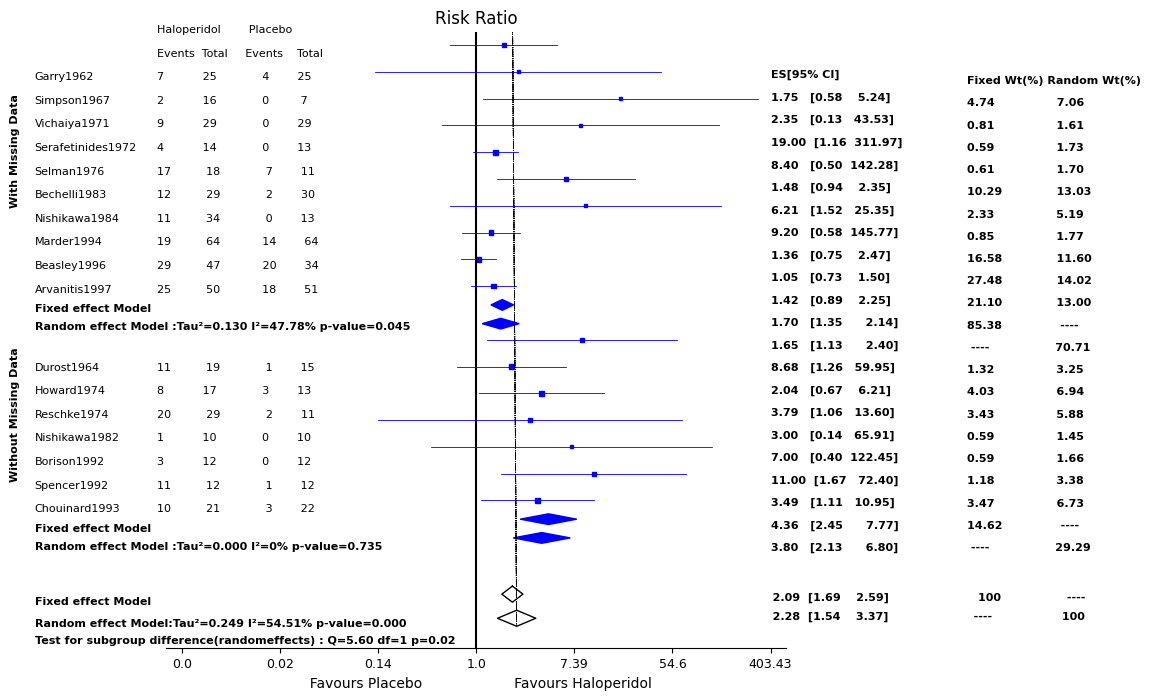

In [6]:
# Figure 3. Forest plot showing the subgroup analysis of studies with and without missing data

import PythonMeta as PMA
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import math
from pylab import gca

def showithmiss(studies):    #studies with missing data
    text = "{0:18}{1:16}\n".format( "Haloperidol ", " Placebo")
    text += "{0:<8}{1:<10}{2:<10}{3:10}{4}\n".format("Events","Total","Events","Total"," ")
    for i in range(len(studies)):
        text += "{0:12}{1:13}{2:^5}{3:>8}\n".format(
        str(studies[i][0]),   #event num of group1
        str(studies[i][1]),   #total num of group1
        str(studies[i][2]),   #event num of group2
        str(studies[i][3]))    #total num of group2
    return text

def showithoutmiss(studies):   #studies without missing data
    text = "{}\n".format("")
    for i in range(len(studies)):
        text += "{0:12}{1:13}{2:^5}{3:>8}\n".format(
        str(studies[i][0]),   #event num of group1
        str(studies[i][1]),   #total num of group1
        str(studies[i][2]),   #event num of group2
        str(studies[i][3]))    #total num of group2
    return text

def ID(studies):    #studies` names
    text = "{0:18}\n".format( " ")
    for i in range(len(studies)):
        text += "{0}\n".format(str(studies[i][4]))
    return text

def rultswithmiss(fixed_results, random_results): #between-study variance for studies with missing data
    text = "{0}\n".format("\n")
    for i in range(1, len(fixed_results)):
        if (fixed_results[i][0]).startswith("<sub>WithMissingdata"):
            text+="{}".format("Fixed effect Model\n")
            text+="Random effect Model :Tau²={0:.3f} I²={1:s} p-value={2:s}\n".format(
                random_results[i][12],
                str(round(random_results[i][9], 2)) + "%",
                random_results[i][8],)
    return text

def rultswithoutmiss(fixed_results, random_results):  #between-study variance  studies without missing data
    text = "{0}\n".format("\n")
    for i in range(1, len(fixed_results)):
        if (fixed_results[i][0]).startswith("<sub>WithoutMissingdata"):
            text+="{}".format("Fixed effect Model\n")
            text+="Random effect Model :Tau²={0:.3f} I²={1:s} p-value={2:s}\n".format(
                random_results[i][12],
                str(round(random_results[i][9], 2)) + "%",
                random_results[i][8],)
    return text

def descrip(fixed_results,random_results):  #show total results
    text = "{}".format("")
    for i in range(1, len(fixed_results)):
        text += "  {0:5.2f}  [{1:.2f}  {2:6.2f}] {3:>25} {4:>20}\n  {5:5.2f}  [{6:.2f}  {7:6.2f}] {8:>25} {9:>20}".format(
            fixed_results[0][1],  # total effect size
            fixed_results[0][3],  # total lower CI
            fixed_results[0][4],  # total higher CI
            "100",
            "----",
            random_results[0][1],  # total effect size
            random_results[0][3],  # total lower CI
            random_results[0][4],  # total higher CI
            "----",
            "100")
        return text

def CI(fixed_results,random_results):  #95% confidence interval
    text = "{0}".format("ES[95% CI]\n")
    for i in range(1, len(fixed_results)):
        if (fixed_results[i][0]).startswith("<sub>"):
            text += "{0:<6.2f} [{1:3.2f}    {2:6.2f}]\n".format(
                fixed_results[i][1],  # total effect size
                fixed_results[i][3],  # total lower CI
                fixed_results[i][4],)
            text += "{0:<6.2f} [{1:3.2f}    {2:6.2f}]\n".format(
                random_results[i][1],  # total effect size
                random_results[i][3],  # total lower CI
                random_results[i][4],)
            continue
        text += "{0:<6.2f} [{1:.2f}{2:8.2f}]\n".format(
                                fixed_results[i][1],   # effect size
                                fixed_results[i][3],   # lower of CI
                                fixed_results[i][4],)
    return text

def showeight(fixed_results,random_results):   #weights
    text = "{0:10} {1}".format("Fixed Wt(%)", "Random Wt(%)\n")
    for i in range(1, len(fixed_results)):
        if (fixed_results[i][0]).startswith("<sub>"):
            text += "{0:<17.2f} {1:>6s}\n".format(
                100*(fixed_results[i][2]/fixed_results[0][2]),
                "----",)
            text += "{0:>5s}{1:>22.2f}\n".format(
                "----",
                100*(random_results[i][2]/random_results[0][2])
                )
            continue
        text +="{0:<18.2f} {1:>5.2f} \n".format(
            100*(fixed_results[i][2]/fixed_results[0][2]),
            100*(random_results[i][2]/random_results[0][2]))
    return text

def totalsub(fixed_results,random_results):  ##between-study variance
    text="Fixed effect Model\n""Random effect Model:Tau²={0:.3f} I²={1:s} p-value={2:s}".format(
    random_results[0][12],
    str(round(random_results[0][9], 2)) + "%",
    random_results[0][11])
    return text

# Forest plot function (modificado do pacote)
def Fig_Forest(size,dpi,es_w_ci,fix_results, titletxt="Risk Ratio",no_ttl=False):
    if es_w_ci[0][0] in "OR,RR" :
        def _x_tran0(x):
            return math.log(x)
        def _x_tran1(x):
            return math.exp(x)
    elif es_w_ci[0][0] in "RD,MD,SMD" :
        def _x_tran0(x):
            return x
        def _x_tran1(x):
            return x
    else:
        Err="error.(failed to get effect size while drawing forest plot)"
        raise Exception(Err)

    myfig = plt.figure(linewidth=1, figsize=size, dpi=dpi)
    myfig.set_size_inches(size)
    plt.title(titletxt)
    ax = gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    xlim=[];y_k=0;subgrp=[]
    for i in range(len(es_w_ci)):
        xlim.append(es_w_ci[i][3])
        xlim.append(es_w_ci[i][4])
        stdname=es_w_ci[i][0]
        if stdname[0:5]=="<sub>":  #this line is a subgroup
            subgrp.append(es_w_ci[i])

    xmin= _x_tran0(min(xlim))
    xmax= _x_tran0(max(xlim))
    xmax=max(abs(xmin),abs(xmax))
    xmin=-xmax
    plt.xlim(xmin*1.1,xmax*1.1)
    ylabel=[i[0].replace("<sub>","") for i in es_w_ci[1:]]
    if no_ttl==True :
        ax.set_yticks(range(len(es_w_ci)))
        ymax=len(es_w_ci)
        ylabel.extend([""])
        y_k=0
    else:
        ax.set_yticks(range(len(es_w_ci)+3))
        ymax=len(es_w_ci)+3
        ylabel.extend(["","Overall","",""])
        y_k=3.5
    plt.ylim(0, ymax)
    ylabel.reverse()
    ax.set_yticklabels(ylabel)
    ax.set_xticklabels([round(_x_tran1(x),2) for x in ax.get_xticks()])
    plt.plot([0,0], [0,len(es_w_ci)+3], 'black')

    if len(subgrp)>0:
        weight_all=subgrp[0][2]
    else:
        weight_all=es_w_ci[0][2]
    N=es_w_ci[0][5];k=0;i_subgrp=0
    for i in range(1,len(es_w_ci)):
        stdname=es_w_ci[i][0]
        if stdname[0:5]=="<sub>":
            i_subgrp+=1
            if i_subgrp>len(subgrp)-1:
                i_subgrp=len(subgrp)-1
            weight_all=subgrp[i_subgrp][2]
            x=[_x_tran0(es_w_ci[i][1]),
               _x_tran0(es_w_ci[i][3]),
               _x_tran0(es_w_ci[i][1]),
               _x_tran0(es_w_ci[i][4]),
               _x_tran0(es_w_ci[i][1])]
            y=[len(es_w_ci)-i+y_k-0.6,
               len(es_w_ci)-i+y_k-0.4,
               len(es_w_ci)-i+y_k-0.2,
               len(es_w_ci)-i+y_k-0.4,
               len(es_w_ci)-i+y_k-0.6]
            if (es_w_ci[i][9]<50) :
                plt.fill(x,y,color="blue", lw=1)
            else :
                plt.plot(x,y, 'blue', lw=1)

            x=[_x_tran0(fix_results[i][1]),
               _x_tran0(fix_results[i][3]),
               _x_tran0(fix_results[i][1]),
               _x_tran0(fix_results[i][4]),
               _x_tran0(fix_results[i][1])]
            y=[len(fix_results)-i+y_k+0.5,
               len(fix_results)-i+y_k+0.3,
               len(fix_results)-i+y_k+0.1,
               len(fix_results)-i+y_k+0.3,
               len(fix_results)-i+y_k+0.5]
            if (fix_results[i][9]<50) :
                plt.fill(x,y,color="blue", lw=1)
            else :
                plt.plot(x,y, 'blue', lw=1)
            continue

        weight=es_w_ci[i][2]/weight_all
        lncolor,lnstyle=("blue","-")
        plt.plot([_x_tran0(es_w_ci[i][3]),_x_tran0(es_w_ci[i][4])], [len(es_w_ci)-i+y_k,len(es_w_ci)-i+y_k], lncolor, linestyle=lnstyle, lw=0.6)
        plt.plot((math.log(es_w_ci[0][1]),0),(math.log(es_w_ci[0][1]),(ymax+200)),linestyle="dotted", lw=0.5,color="k")

        k=weight*0.2+0.05
        x=[_x_tran0(es_w_ci[i][1])-k*(xmax*2.2/ymax),
           _x_tran0(es_w_ci[i][1])+k*(xmax*2.2/ymax),
           _x_tran0(es_w_ci[i][1])+k*(xmax*2.2/ymax),
           _x_tran0(es_w_ci[i][1])-k*(xmax*2.2/ymax),
           _x_tran0(es_w_ci[i][1])-k*(xmax*2.2/ymax)]
        y=[len(es_w_ci)-i+y_k+k,
           len(es_w_ci)-i+y_k+k,
           len(es_w_ci)-i+y_k-k,
           len(es_w_ci)-i+y_k-k,
           len(es_w_ci)-i+y_k+k]
        plt.fill(x,y,color=lncolor, lw=1)

    if no_ttl==True:
        pass
    else:
        x=[_x_tran0(es_w_ci[0][1]),
           _x_tran0(es_w_ci[0][3]),
           _x_tran0(es_w_ci[0][1]),
           _x_tran0(es_w_ci[0][4]),
           _x_tran0(es_w_ci[0][1])]
        y=[1.4,1.1,0.8,1.1,1.4]
        if (es_w_ci[0][9]<50) :
            plt.fill(x,y,color="black", lw=1)
        else :
            plt.plot(x,y, 'black', lw=1)

        x=[_x_tran0(fix_results[0][1]),
           _x_tran0(fix_results[0][3]),
           _x_tran0(fix_results[0][1]),
           _x_tran0(fix_results[0][4]),
           _x_tran0(fix_results[0][1])]
        y=[2.3,2,1.7,2,2.3]
        if (es_w_ci[0][9]<50) :
            plt.fill(x,y,color="black", lw=1)
        else :
            plt.plot(x,y, 'black', lw=1)

    plt.xlabel("{:<38}{:<s}".format("  Favours Placebo","Favours Haloperidol"),fontsize=10)
    return myfig

# Test for subgroup differences
def subQ(womiss_random,miss_random):
    WY2wo=((math.log(womiss_random[0][1]))**2)*womiss_random[0][2]
    WY2wm=((math.log(miss_random[0][1]))**2)*miss_random[0][2]
    WY2=WY2wo+WY2wm
    WYwo=(math.log(womiss_random[0][1]))*womiss_random[0][2]
    WYwm=(math.log(miss_random[0][1]))*miss_random[0][2]
    WYsq=(WYwo+WYwm)**2
    W=womiss_random[0][2]+miss_random[0][2]
    Q=round(WY2-(WYsq/W),3)
    return Q

def pvalue(womiss_random,miss_random):
    Qpv=(1-scipy.stats.chi2.cdf(subQ(womiss_random,miss_random),df=1))
    Qp=round((Qpv),2)
    return Qp

def main(setting):
    d = PMA.Data()
    m = PMA.Meta()
    f = PMA.Fig()

    d.datatype = setting["datatype"]
    studies = d.getdata(d.readfile("/content/subgroup.txt"))
    withmiss=d.getdata(d.readfile("/content/missing.txt"))
    withoutmiss=d.getdata(d.readfile("/content/no_missing.txt"))
    m.subgroup = d.subgroup
    m.datatype = d.datatype
    m.models = setting["models"][0]
    m.algorithm = setting["algorithm"]
    m.effect = setting["effect"]
    results = m.meta(studies)
    m.models = setting["models"][1]
    res_random = m.meta(studies)

    Fig_Forest((8,8),dpi=100,es_w_ci=(res_random),fix_results=(results))
    plt.yticks([])
    plt.text(10,2.8,showeight(results,res_random),fontsize=8,multialignment="left",linespacing=2.53,weight="bold")
    plt.text(6,2.8,CI(results, res_random),fontsize=8,multialignment="left",linespacing=2.53,weight="bold")
    plt.text(-9,12.4,ID(withmiss),multialignment="left",fontsize=8,linespacing=2.7)
    plt.text(-9,4.2,ID(withoutmiss),multialignment="left",fontsize=8,linespacing=2.7)
    plt.text(-9,11.2,rultswithmiss(results,res_random),multialignment="left",fontsize=8,linespacing=2,weight="bold")
    plt.text(-9,3,rultswithoutmiss(results,res_random),multialignment="left",fontsize=8,linespacing=2,weight="bold")
    plt.text(-9.5,6.3,"Without Missing Data",multialignment="left",fontsize=8,weight="bold",rotation=90)
    plt.text(-9.5,16.5,"With Missing Data",multialignment="left",fontsize=8,weight="bold",rotation=90)
    plt.text(-9,0.8,totalsub(results, res_random),multialignment="left",fontsize=8,weight="bold",linespacing=2.5)
    plt.text(-6.5,12.4,showithmiss(withmiss),multialignment="left",fontsize=8,linespacing=2.7)
    plt.text(-6.5,4.2,showithoutmiss(withoutmiss),multialignment="left",fontsize=8,linespacing=2.7)
    plt.text(5.8,1,descrip(results,res_random),fontsize=8, style='normal', ha="left",
     va='bottom',multialignment="left",linespacing=2,weight="bold")
    plt.text(-9,0.1,"Test for subgroup difference(randomeffects) : Q=5.60 df=1 p=0.02",fontsize=8, style='normal', ha="left", va='bottom',multialignment="left",linespacing=2.5,weight="bold")
    plt.savefig("subForest_figure3.png", dpi=300,bbox_inches="tight",orientation="landscape",transparent=True)
    plt.show()

if __name__ == '__main__':
    settings = {"datatype": "CATE",
                "models": ["Fixed","Random"],
                "algorithm": "MH",
                "effect": "RR"}
    main(settings)

## Criação dos datasets de imputação (ICA-0, ICA-1, ICA-WORST, ICA-BEST)

In [7]:
# ICA-0
import pandas as pd
import numpy as np

df = pd.read_csv("/content/Cochrane.csv")
df.insert(df.columns.get_loc('fail.h'),"exptotal",df["resp.h"]+df["fail.h"]+df["drop.h"])
df.insert(df.columns.get_loc('fail.p'),"conttotal",df["resp.p"]+df["fail.p"]+df["drop.p"])
new_df = df.drop(["fail.h","drop.h","fail.p","drop.p"],axis=1)
new_df.to_csv('ICA-0.csv',index = False)
print("ICA-0.csv criado.")

# ICA-1
df = pd.read_csv("/content/Cochrane.csv")
df.insert(df.columns.get_loc('resp.h'),"resph",df["resp.h"]+df["drop.h"])
df.insert(df.columns.get_loc('resp.h'),"exptotal",df["resp.h"]+df["fail.h"]+df["drop.h"])
df.insert(df.columns.get_loc('resp.p'),"respp",df["resp.p"]+df["drop.p"])
df.insert(df.columns.get_loc('resp.p'),"conttotal",df["resp.p"]+df["fail.p"]+df["drop.p"])
new_df = df.drop(["resp.h","fail.h","drop.h","resp.p","fail.p","drop.p"],axis=1)
new_df.to_csv('ICA-1.csv',index = False)
print("ICA-1.csv criado.")

# ICA-WORST
df = pd.read_csv("/content/Cochrane.csv")
df.insert(df.columns.get_loc('resp.h'),"resph",df["resp.h"]+df["drop.h"])
df.insert(df.columns.get_loc('resp.h'),"exptotal",df["resp.h"]+df["fail.h"]+df["drop.h"])
df.insert(df.columns.get_loc('resp.p'),"respp",df["resp.p"]+df["drop.p"])
df.insert(df.columns.get_loc('resp.p'),"conttotal",df["resp.p"]+df["fail.p"]+df["drop.p"])
new_df = df.drop(["resp.h","fail.h","drop.h","resp.p","fail.p","drop.p"],axis=1)
new_df.to_csv('ICA-worst.csv',index = False)
print("ICA-worst.csv criado.")

# ICA-BEST
df = pd.read_csv("/content/Cochrane.csv")
df.insert(df.columns.get_loc('resp.h'),"resph",df["resp.h"]+df["drop.h"])
df.insert(df.columns.get_loc('resp.h'),"exptotal",df["resph"]+df["fail.h"])
df.insert(df.columns.get_loc('fail.p'),"conttotal",df["resp.p"]+df["fail.p"]+df["drop.p"])
new_df = df.drop(["resp.h","fail.h","drop.h","fail.p","drop.p"],axis=1)
new_df.to_csv('ICA-best.csv',index = False)
print("ICA-best.csv criado.")

ICA-0.csv criado.
ICA-1.csv criado.
ICA-worst.csv criado.
ICA-best.csv criado.


## Figura 4 – Comparação de métodos de imputação (EffectMeasurePlot – zEpid)

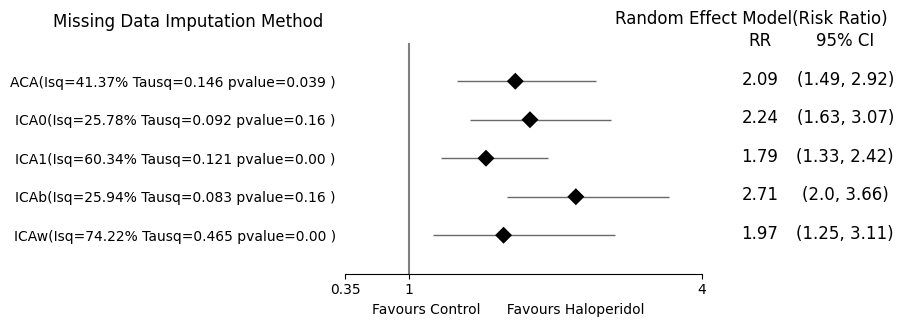

In [8]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import zepid
from zepid.graphics import EffectMeasurePlot

labs = ["ACA(Isq=41.37% Tausq=0.146 pvalue=0.039 )",
        "ICA0(Isq=25.78% Tausq=0.092 pvalue=0.16 )",
        "ICA1(Isq=60.34% Tausq=0.121 pvalue=0.00 )",
        "ICAb(Isq=25.94% Tausq=0.083 pvalue=0.16 )",
        "ICAw(Isq=74.22% Tausq=0.465 pvalue=0.00 )"]
measure = [2.09,2.24,1.79,2.71,1.97]
lower = [1.49,1.63,1.33,2.00,1.25]
upper = [2.92,3.07,2.42,3.66,3.11]

p = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
p.labels(effectmeasure='RR')
p.colors(pointshape="D")
ax = p.plot(figsize=(7,3), t_adjuster=0.09, max_value=4, min_value=0.35)

plt.title("Random Effect Model(Risk Ratio)",loc="right",x=1, y=1.045)
plt.suptitle("Missing Data Imputation Method",x=-0.1,y=0.98)
ax.set_xlabel("Favours Control      Favours Haloperidol       ", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.savefig("Missing_Data_Imputation_Method.png",bbox_inches='tight')
plt.show()

## Figura 5 – Funnel plot

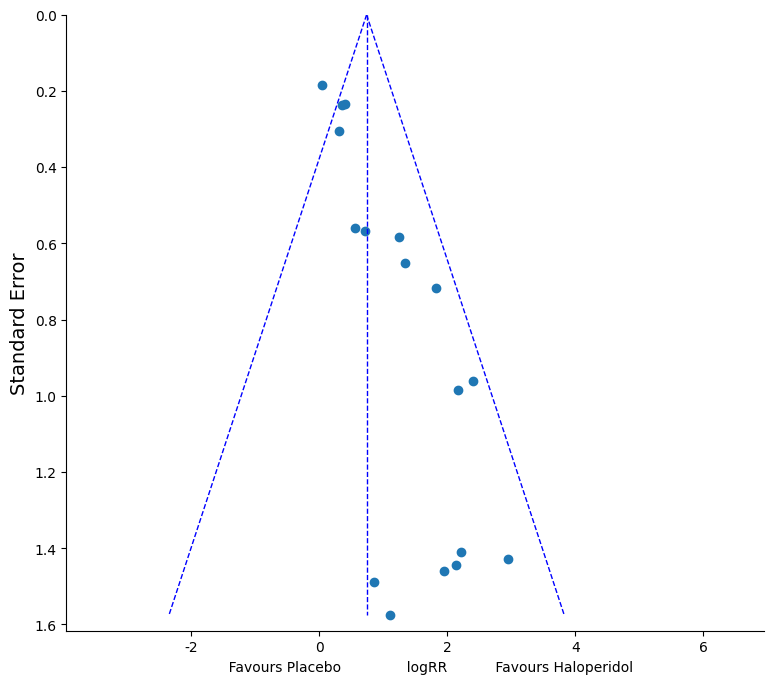

In [9]:
import PythonMeta as PMA
import matplotlib.pyplot as plt
import math
from pylab import gca
from matplotlib.lines import Line2D

def logES(rults):
    logES=[]
    for i in range(1,len(rults)):
        Yi=math.log(rults[i][1])
        logES.append(Yi)
    return logES

# SE para random (via pesos)
def SE(rults):
    SE=[]
    for i in range(1,len(rults)):
        VM=math.sqrt(1/rults[i][2])
        SE.append(VM)
    return SE

# SE no modelo fixo (campo 6)
def SEFix(rults):
    SE=[]
    for i in range(1,len(rults)):
        se=rults[i][6]
        SE.append(se)
    return SE

def funnelplot(rults):
    fig=plt.figure(figsize=(9,8))
    x=logES(rults)
    y=SEFix(rults)
    plt.plot(x,y,"o",lw=1)
    plt.xlim(min(x)-4,max(x)+4)
    plt.ylim(max(y)+0.04,0)
    tes=(rults[0][1])
    logtes=math.log(tes)
    plt.plot ([logtes,logtes],[0,max(y)],color="blue", linestyle="--", lw=1)
    plt.plot ([logtes,logtes-(1.96*max(y))],[0,max(y)],color="blue", linestyle="--", lw=1)
    plt.plot ([logtes,logtes+(1.96*max(y))],[0,max(y)],color="blue", linestyle="--", lw=1)
    ax = gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel("Standard Error",fontsize=14,rotation=90 )
    plt.xlabel("       Favours Placebo               logRR           Favours Haloperidol",fontsize=10 )

def main(setting):
    d = PMA.Data()
    m = PMA.Meta()
    f = PMA.Fig()
    d.datatype = setting["datatype"]
    studies = d.getdata(d.readfile("/content/ Haloperidol.txt"))
    m.datatype = d.datatype
    m.models = setting["models"]
    m.algorithm = setting["algorithm"]
    m.effect = setting["effect"]
    results = m.meta(studies)
    funnelplot(results)
    # f.funnel(results)  # original do pacote
    plt.savefig("Funnelplot_figure5.jpg",transparent=False,dpi=300)
    plt.show()

if __name__ == '__main__':
    settings = {"datatype": "CATE",
                "models": "FIXED",
                "algorithm": "MH",
                "effect": "RR"}
    main(settings)

## Contour-enhanced funnel plot

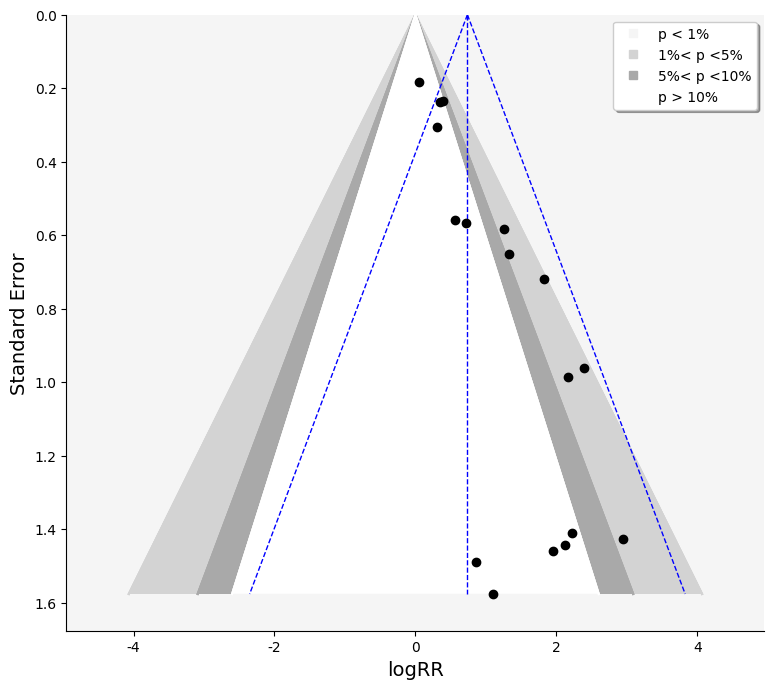

In [10]:
import PythonMeta as PMA
import matplotlib.pyplot as plt
import math
from pylab import gca
from matplotlib.lines import Line2D

# Reaproveita logES e SEFix definidos na célula anterior

def CEfunnelplot(rults):      #to draw contour enhanced funnel plot
    fig=plt.figure(figsize=(9,8))
    ax=gca()
    x=logES(rults)
    y= SEFix(rults)
    plt.xlim(min(x)-5,max(x)+2)
    plt.ylim(max(y)+0.1,0)
    ax.set_facecolor(color="whitesmoke")
    tes=(rults[0][1])
    logtes=math.log(rults[0][1])
    plt.plot ([0,(-2.58*max(y))],[0,max(y)], linestyle="None", lw=1)
    plt.plot ([0,(2.58*max(y))],[0,max(y)], linestyle="None", lw=1)
    trianglex = [ -2.58*max(y), 0, 2.58*max(y)]
    triangley = [ max(y),0, max(y)]
    for i in range(3):
        plt.plot(trianglex, triangley,color="lightgray")
    plt.fill(trianglex, triangley,"lightgray")
    plt.plot ([0,(-1.96*max(y))],[0,max(y)], linestyle="None", lw=1)
    plt.plot ([0,(1.96*max(y))],[0,max(y)], linestyle="None", lw=1)
    trianglex = [ -1.96*max(y), 0,1.96*max(y)]
    triangley = [ max(y),0, max(y)]
    for i in range(3):
        plt.plot(trianglex, triangley,color="darkgrey")
    plt.fill(trianglex, triangley,"darkgrey")
    plt.plot ([0,(-1.65*max(y))],[0,max(y)], linestyle="None", lw=1)
    plt.plot ([0,(1.65*max(y))],[0,max(y)], linestyle="None", lw=1)
    trianglex = [ -1.65*max(y), 0,1.65*max(y)]
    triangley = [ max(y),0, max(y)]
    for i in range(3):
        plt.plot(trianglex, triangley,color="white")
    plt.fill(trianglex, triangley,"white")
    plt.plot ([logtes,logtes],[0,max(y)],color="blue", linestyle="--", lw=1)
    plt.plot ([logtes,logtes-1.96*max(y)],[0,max(y)],color="blue", linestyle="--", lw=1)
    plt.plot ([logtes,logtes+1.96*max(y)],[0,max(y)],color="blue", linestyle="--", lw=1)
    plt.plot(x,y,"o",lw=1,color="k")
    ax = gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    colors = ['whitesmoke', 'lightgray', 'darkgrey',"white"]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='None', marker="s") for c in colors]
    labels = ["p < 1%","1%< p <5%","5%< p <10%","p > 10%"]
    plt.legend(lines, labels,shadow=True)
    plt.xlabel("logRR",fontsize=14 )
    plt.ylabel("Standard Error",fontsize=14,rotation=90 )
    plt.savefig("Contour_Enhanced_Funnel_plot.jpg")
    plt.show()

def main(setting):
    d = PMA.Data()
    m = PMA.Meta()
    d.datatype = setting["datatype"]
    studies = d.getdata(d.readfile("/content/ Haloperidol.txt"))
    m.datatype = d.datatype
    m.models = setting["models"]
    m.algorithm = setting["algorithm"]
    m.effect = setting["effect"]
    results = m.meta(studies)
    CEfunnelplot(results)

if __name__ == '__main__':
    settings = {"datatype": "CATE",
                "models": "FIXED",
                "algorithm": "MH",
                "effect": "RR"}
    main(settings)